# Time series analysis of CO2 emission data

#### What is time series analysis?

Time series analysis is a statistical technique that is used to examine data that is collected over time. It involves the use of statistical models to identify underlying patterns, trends, and other characteristics of the collected data. The main objective of using time series analysis is to use historical data to forecast future values of the time series. This is often done using sophisticated models, using machine learning to train a model with the recorded data, allowing predictions to made for the future behaviour of the time series.

In this notebook, I will be using time series analysis to analyse CO2 emission data recorded at Mauna Loa. I will train a ML model using the dataset, then make predictions for the future atomospheric CO2 values.

## Import libraries

In [129]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import seaborn as sns
import datetime
import itertools

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Clean and prepare dataset

Before starting any analysis, the following steps need to be performed to clean and prepare the data to enable statistical models to be used.

**1. Import dataset**

In [2]:
df = pd.read_csv('co2_mm_mlo.csv') # Use pandas to import dataset.

**2. Check dataset**

In [3]:
df.head() #Check the labels and the first few entries of the dataset. 

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [130]:
df.info() # Check data types and size of dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            776 non-null    int64  
 1   month           776 non-null    int64  
 2   decimal date    776 non-null    float64
 3   average         776 non-null    float64
 4   deseasonalized  776 non-null    float64
 5   ndays           776 non-null    int64  
 6   sdev            776 non-null    float64
 7   unc             776 non-null    float64
 8   Date            776 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 54.7+ KB


In [131]:
df.shape # Compare total ds shape with non-null counts above.

(776, 9)

In [132]:
df.isnull().sum() #Confirm null counts

year              0
month             0
decimal date      0
average           0
deseasonalized    0
ndays             0
sdev              0
unc               0
Date              0
dtype: int64

There are no null values in this dataset so we dont have to drop/replace any data.

**3. Prepare data**

We can see that there are date columns, however, there is nothing in a standardized date format. We can create a new column in a standard format using existing year and month data.

In [133]:
df['Date'] = ''
for i in range(0,len(df)):
    df['Date'][i] = datetime.datetime(df['year'][i], df['month'][i], 1) # Create a new column that combines existing year and month values
    
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc,Date
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99,1958-03-01 00:00:00
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99,1958-04-01 00:00:00
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99,1958-05-01 00:00:00
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99,1958-06-01 00:00:00
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99,1958-07-01 00:00:00


Now we can reformat new df to include only the data we need for our analysis.

In [134]:
df_complete = df.drop(['decimal date', 'deseasonalized', 'ndays', 'sdev', 'unc'], axis=1) # Drop unessential columns
df_complete.rename(columns = {'average':'average_CO2_count_ppm'}, inplace=True) # Rename columns
df_complete.head()

,year,month,average_CO2_count_ppm,Date
0,1958,3,315.70,1958-03-01 00:00:00
1,1958,4,317.45,1958-04-01 00:00:00
2,1958,5,317.51,1958-05-01 00:00:00
3,1958,6,317.24,1958-06-01 00:00:00
4,1958,7,315.86,1958-07-01 00:00:00


Finally, we can make date column the dataframe's index.

In [135]:
df_complete.set_index('Date', inplace = True)  #set the date column as the index column
df_complete.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01'],
              dtype='datetime64[ns]', name='Date', length=776, freq=None)

In [11]:
df_complete.describe()

,year,month,average_CO2_count_ppm
count,776.000000,776.000000,776.000000
mean,1990.000000,6.500000,357.586302
std,18.681162,3.444303,30.495780
min,1958.000000,1.000000,312.430000
25%,1974.000000,4.000000,329.685000
50%,1990.000000,6.500000,354.065000
75%,2006.000000,9.000000,382.420000
max,2022.000000,12.000000,420.990000


In [12]:
df_complete.head()

,year,month,average_CO2_count_ppm
Date,,,
1958-03-01,1958,3,315.70
1958-04-01,1958,4,317.45
1958-05-01,1958,5,317.51
1958-06-01,1958,6,317.24
1958-07-01,1958,7,315.86


## Analyse the data

Now that we have data in an acceptable format, we can start to analyse its contents.

Firstly, lets plot the time series:

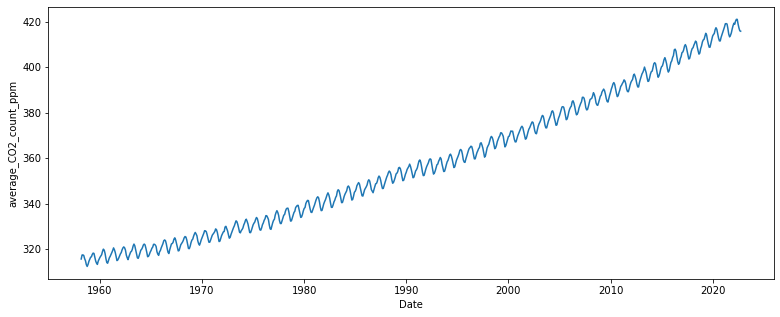

In [15]:
plt.figure(figsize=(13, 5))
sns.lineplot(x = "Date", y = "average_CO2_count_ppm", data = df_complete)
plt.show()

Let's take a look at how the average CO2 count has changed by year and by decade.

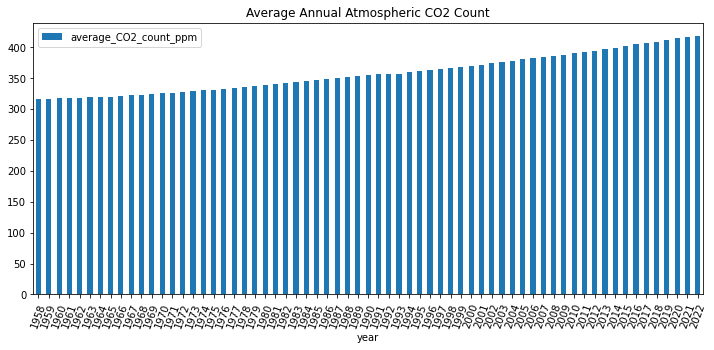

In [142]:
yearly = df_complete[['year','average_CO2_count_ppm']].groupby(['year']).mean()

plt.rcParams["figure.figsize"] = [12,5]
yearly.plot.bar(rot=70, title="Average Annual Atmospheric CO2 Count", align='center')
plt.show(block=True)

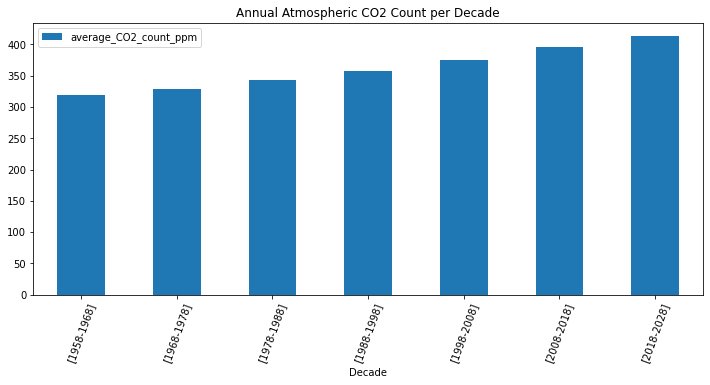

In [204]:
decade = df_complete.resample('10AS').mean()
decade = decade.drop(['year', 'month'], axis=1) # Drop unessential columns

b=[]
for i in range(len(decade)):
    a=['{}-{}'.format((decade.index.year[i]) , (decade.index.year[i]+10))]
    b.append(a)

decade['Decade'] = b

plt.rcParams["figure.figsize"] = [12,5]
decade.plot.bar(x = 'Decade', y= 'average_CO2_count_ppm', rot=70, title="Annual Atmospheric CO2 Count per Decade", align='center')
date_form = decade
plt.show(block=True)

Now we have a general understanding of how the CO2 mesurments have been changing over time, lets start prcessing the data in order to make forecasts.

In [14]:
df_CO2_count = df_complete[['average_CO2_count_ppm']] #Create new dataframe to hold CO2 data only.
df_CO2_count.head()

,average_CO2_count_ppm
Date,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86


## Process Time Series & Test for Stationarity

The Dicky Fuller test can be used to determine the stationarity of a time series. It provides a statistical value that can be combined with the simple eye test. A time series (TS) being stationary indicates we can use autoregressive and moving average models to predict future values based of past data. First, we will create functions that allow us to test a Time Series' stationairty and plot the TS to help visualise this.

In [237]:
#define a function to plot the rolling mean and rolling standard deviation of the time series
def TestStationaryPlot(ts):
    rolling_mean = ts.rolling(window = 12, center = False).mean()
    rolling_std = ts.rolling(window = 12, center = False).std()
    
    rolling_mean.dropna(inplace = True)
    rolling_std.dropna(inplace = True)
    
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title('Rolling Mean & Standard Deviation', fontsize = 15)
    
    diff_factor = (rolling_mean.mean()/rolling_std.mean())
    
    if int(diff_factor) > 10:  # Plot 1 (STD is 1 factor smaller than the mean values)
        # using the twinx() for creating another
        # axes object for secondary y-Axis
        ax2 = ax.twinx()
        ax.plot(ts, color = 'blue',label = 'Original TS')
        ax.plot(rolling_mean, color = 'red', label = 'TS Rolling Mean')
        ax2.plot(rolling_std, color ='black', label = 'TS Rolling Std')
    
        # giving labels to the axises
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Total CO2 count', fontsize = 15)
        ax.legend(loc=0, fontsize = 15)
        ax2.legend(loc=0,bbox_to_anchor=(0.26, 0.82), fontsize = 15)
    
        # secondary y-axis label
        ax2.set_ylabel('Total CO2 count (STD axis)', fontsize = 15)
        # defining display layout
        #plt.legend(loc=0, fontsize = 15)
        plt.tight_layout()
    
    else: # Plot 1 (STD is less than 10 factor smaller than the mean values)
        ax.plot(ts, color = 'blue',label = 'Original TS')
        ax.plot(rolling_mean, color = 'red', label = 'TS Rolling Mean')
        ax.plot(rolling_std, color ='black', label = 'TS Rolling Std')
    
        # giving labels to the axises
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Total CO2 count', fontsize = 15)
        ax.legend(loc=0, fontsize = 15)
        plt.tight_layout()

#define a function to perform the Dicky Fuller test on the time series
def DFTestStationary(ts):
    print('Dicky Fuller test:')
    df_test = adfuller(ts.iloc[:,0].values, autolag = 'AIC')
    df_test[4].items()
    df_output = pd.Series(df_test[0:4], index=['Test statistic', 'p-value', 'Lags used', 'No of observations used']) #show test statistic value
    for key, value in df_test[4].items():
        df_output['Critical value (%s)' %key] = value
    print(df_output) #show critical values and p value

Dicky Fuller test:
Test statistic               6.002797
p-value                      1.000000
Lags used                   21.000000
No of observations used    754.000000
Critical value (1%)         -3.439053
Critical value (5%)         -2.865381
Critical value (10%)        -2.568815
dtype: float64


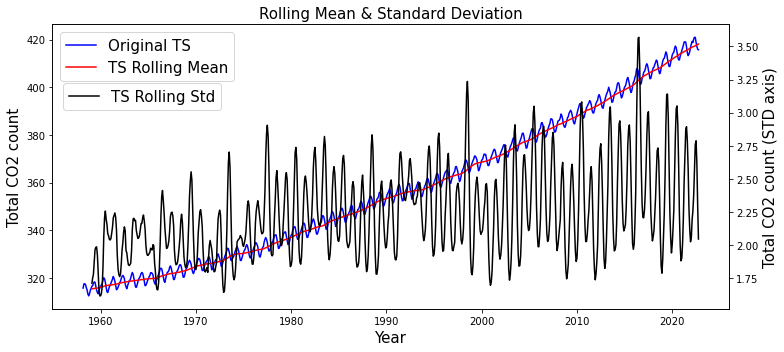

In [238]:
TestStationaryPlot(df_CO2_count)  #Perform ADF test on TS
DFTestStationary(df_CO2_count) #Plot TS, rolling mean and STD.

Analysing the unmodified TS, we can see that it is not stationary as the p-value is >0.05 and the test statistic is greater than the critical values. 

Lets examine the orginal time series to show it's trend and seasonal components.

We can extract trend components from the range and plot the trend, seasonal and residual graphs. This shows us how the components contribute to the overall TS.

In [239]:
decompose = seasonal_decompose(df_CO2_count, model='additive') #Use seasonal decompose function to break down TS

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

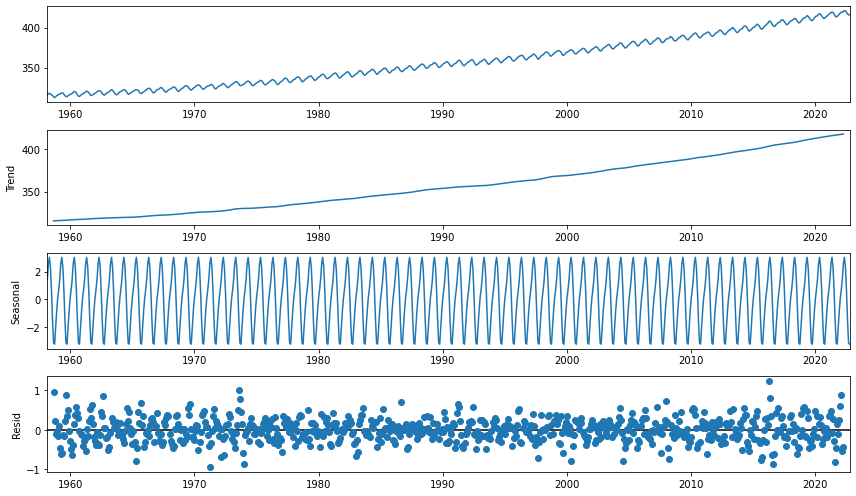

In [240]:
plt.rcParams["figure.figsize"] = [12,7]
decompose.plot()
plt.show()

These plots show the components of the average CO2 count over time. It is important to note the trend is rising, showing the average CO2 concentration in the atompsphere is increasing. 

In order to use predictive tools, the time series needs to be stationary. We can transform the data to try and achieve stationarity in the TS. **There are several methods to achieve stationarity;**

**1. Taking the Time Series' rolling mean and exponentially weighted mean.**

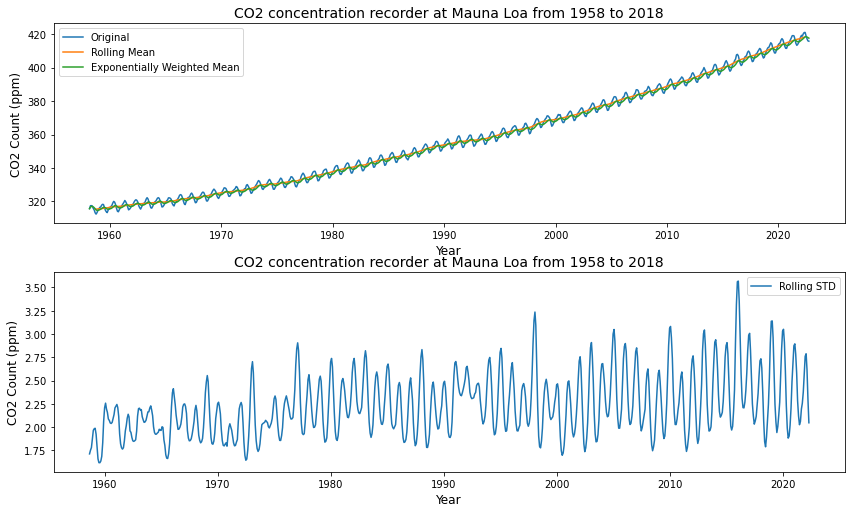

In [241]:
#rolling mean
rol_mean = df_CO2_count.rolling(window=12, center=True).mean()

#exponentially weighted mean
ewm = df_CO2_count.ewm(span=12).mean()

#Rolling standard deviation
rolling_std = df_CO2_count.rolling(window=12, center=True).std()

#Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize =(12,7))


#Temp graph with rolling mean and exp weighted mean
ax1.plot(df_CO2_count, label = 'Original')
ax1.plot(rol_mean, label = 'Rolling Mean')
ax1.plot(ewm, label = 'Exponentially Weighted Mean')
ax1.set_title('CO2 concentration recorder at Mauna Loa from 1958 to 2018', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('CO2 Count (ppm)', fontsize=12)
ax1.legend()

fig.tight_layout()

#Temp graph with rolling standard deviation
ax2.plot(rolling_std, label = 'Rolling STD')
ax2.set_title('CO2 concentration recorder at Mauna Loa from 1958 to 2018', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('CO2 Count (ppm)', fontsize=12)
ax2.legend()


Now, lets apply the Dicky Fuller test to this smoothed data.

Dicky Fuller test:
Test statistic               4.967246
p-value                      1.000000
Lags used                   14.000000
No of observations used    750.000000
Critical value (1%)         -3.439099
Critical value (5%)         -2.865401
Critical value (10%)        -2.568826
dtype: float64


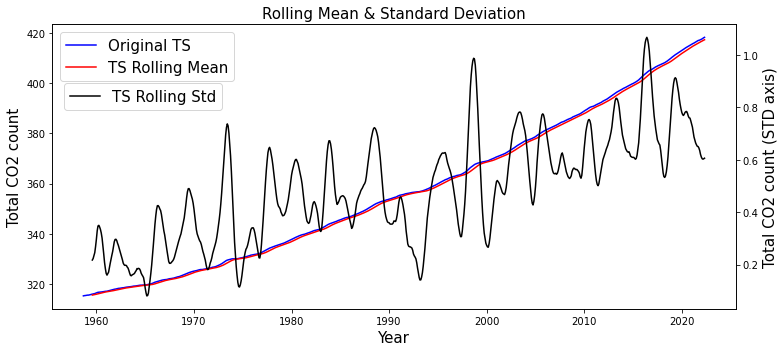

In [242]:
rol_mean.dropna(inplace=True)
ewm.dropna(inplace=True)

#Apply to rolling mean
TestStationaryPlot(rol_mean)
DFTestStationary(rol_mean)

Dicky Fuller test:
Test statistic               6.192601
p-value                      1.000000
Lags used                   19.000000
No of observations used    756.000000
Critical value (1%)         -3.439029
Critical value (5%)         -2.865371
Critical value (10%)        -2.568810
dtype: float64


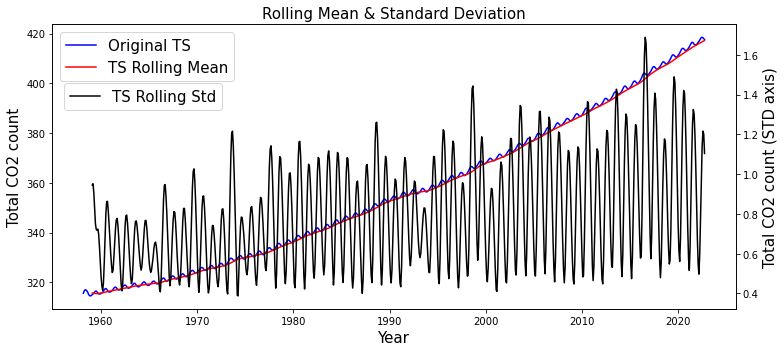

In [243]:
#Apply to exponentially weighted  mean
TestStationaryPlot(ewm)
DFTestStationary(ewm)

Both test results show a p-value of greater than 0.05, therefore these timeseries are still not stationary (this is obviously shown in the plots as well as the Dicky Fuller test). Weighted averaging may smooth data, however it does not remove trends and therefore, this data still isn't stationary.

### 2. Use differencing to remove rolling mean or exponentially weighted average from original series.

Differencing is a method used to try and eliminate seasonal and trend components from a time series. We can subtract a set of values from the TS to try and achieve stationarity. This can by done in a variety of ways, the first of which, subtracting MAs from the TS, is shown below.

In [244]:
diff_rol_mean = df_CO2_count - rol_mean
diff_rol_mean.dropna(inplace = True)

In [245]:
diff_ewm = df_CO2_count - ewm
diff_ewm.dropna(inplace = True)

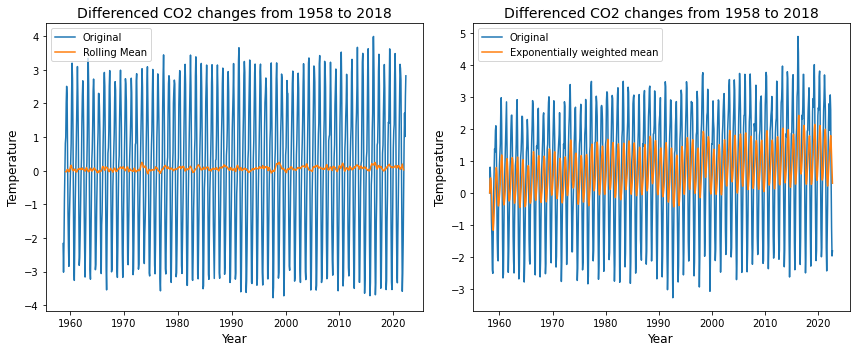

In [248]:
df_rol_mean_diff = diff_rol_mean.rolling(window = 12, center = True).mean()
df_rol_mean_diff.dropna(inplace = True)


#Exponentially weighted mean of the difference
df_ewm_diff = diff_ewm.ewm(span = 12).mean()
df_ewm_diff.dropna(inplace = True)

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

#Diff graph with the rolling mean
ax1.plot(diff_rol_mean, label = 'Original')
ax1.plot(df_rol_mean_diff, label = 'Rolling Mean')
ax1.set_title('Differenced CO2 changes from 1958 to 2018', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.legend()

#Diff graph with the exponentially weghted mean
ax2.plot(diff_ewm, label = 'Original')
ax2.plot(df_ewm_diff, label = 'Exponentially weighted mean')
ax2.set_title('Differenced CO2 changes from 1958 to 2018', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Temperature', fontsize=12)
ax2.legend()

plt.tight_layout()

Now apply the Dicky Fuller test to check hypothesis that the time series are now stationary.

Dicky Fuller test:
Test statistic            -5.669878e+00
p-value                    8.973080e-07
Lags used                  1.900000e+01
No of observations used    7.340000e+02
Critical value (1%)       -3.439290e+00
Critical value (5%)       -2.865486e+00
Critical value (10%)      -2.568871e+00
dtype: float64


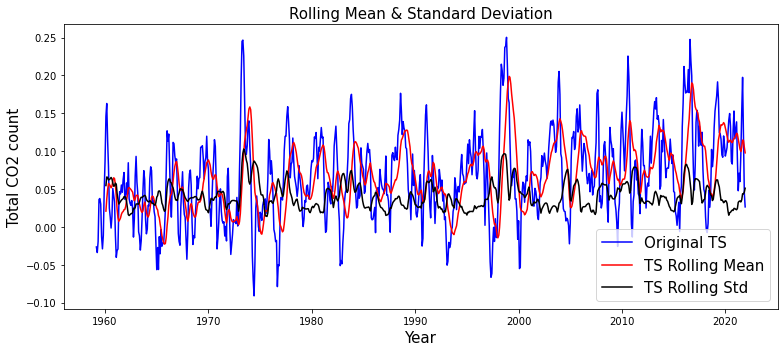

In [249]:
#Apply to df_rol_mean_diff
TestStationaryPlot(df_rol_mean_diff)
DFTestStationary(df_rol_mean_diff)

Dicky Fuller test:
Test statistic              -2.427482
p-value                      0.134129
Lags used                   21.000000
No of observations used    754.000000
Critical value (1%)         -3.439053
Critical value (5%)         -2.865381
Critical value (10%)        -2.568815
dtype: float64


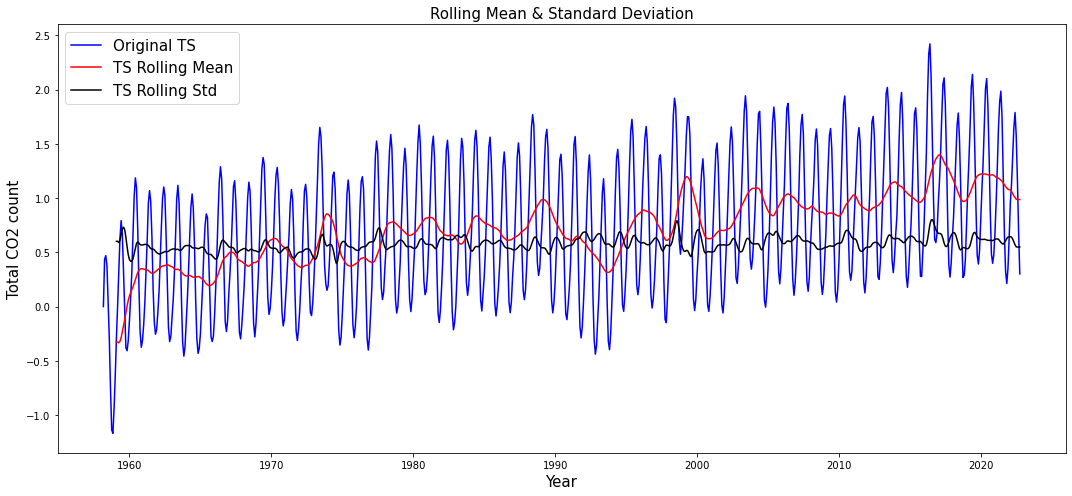

In [28]:
#Apply to df_ewm_diff
TestStationaryPlot(df_ewm_diff)
DFTestStationary(df_ewm_diff)

Taking the difference between the weighted averages and the oringinal time series has improved the p-value by removing the trend, however, there is still a seasonal component within the resultant time series and therefore, the time series is not stationary.

### 3. Taking the log of the times series

Another method to try and create stationarity is to take the log of the time series. This removes any exponential vairance from the time series, thus may help in achieving stationarity.

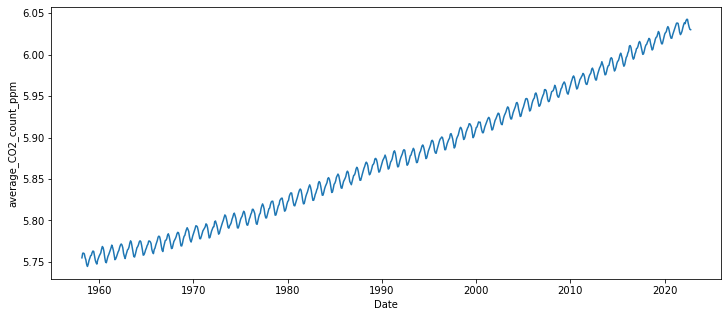

In [251]:
log_co2 = np.log(df_CO2_count)

plt.figure(figsize=(12, 5))
sns.lineplot(x = "Date", y = "average_CO2_count_ppm", data = log_co2)
plt.show()

Clearly, taking the log of the time series has not created stationarity. The trend is relatively linear, therefore taking the log has had a minimal effect.

### 4. Perform a simple differencing transformation, that is differncing a previous value in the time series from the current value.

As mentioned previously, we can subtract a set of values from the TS to try and achieve stationarity. Another way of doing this is differencing. Differencing is the method of subtracting a value n positions before the current data point. This method helps eliminate seasonality and trends from the TS. 

There are different types of differencing that we will use. These are;
a) First differencing
b) Seasonal differencing
c) Seasonal first differencing

#### a) First difference

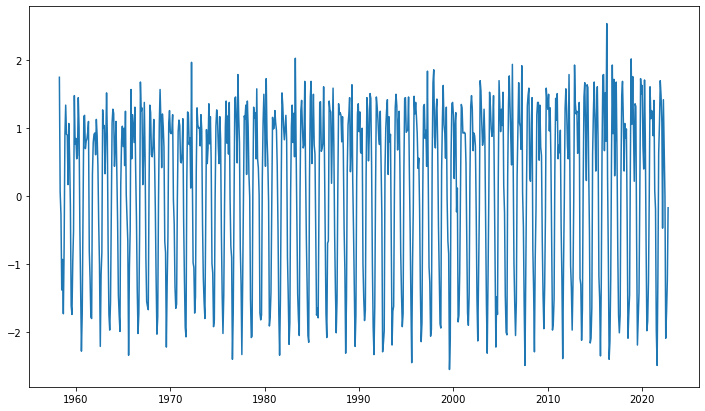

In [252]:
dataset_shifted_first = df_CO2_count - df_CO2_count.shift(1) #1st difference
dataset_shifted_first.dropna(inplace = True)

plt.plot(dataset_shifted_first)

Dicky Fuller test:
Test statistic            -5.718879e+00
p-value                    7.016390e-07
Lags used                  2.100000e+01
No of observations used    7.530000e+02
Critical value (1%)       -3.439064e+00
Critical value (5%)       -2.865386e+00
Critical value (10%)      -2.568818e+00
dtype: float64


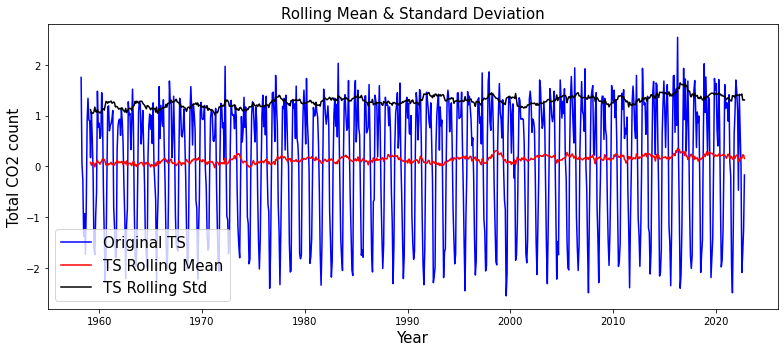

In [253]:
TestStationaryPlot(dataset_shifted_first)
DFTestStationary(dataset_shifted_first)

#### b) Seasonal difference

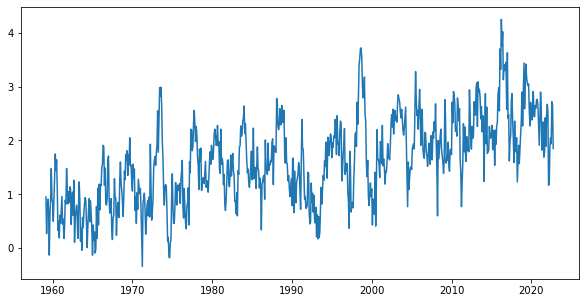

In [254]:
dataset_shifted_season = df_CO2_count - df_CO2_count.shift(12) #Seasonal difference
dataset_shifted_season.dropna(inplace = True)

plt.figure(figsize = (10,5))
plt.plot(dataset_shifted_season)

Dicky Fuller test:
Test statistic              -3.645917
p-value                      0.004941
Lags used                   13.000000
No of observations used    750.000000
Critical value (1%)         -3.439099
Critical value (5%)         -2.865401
Critical value (10%)        -2.568826
dtype: float64


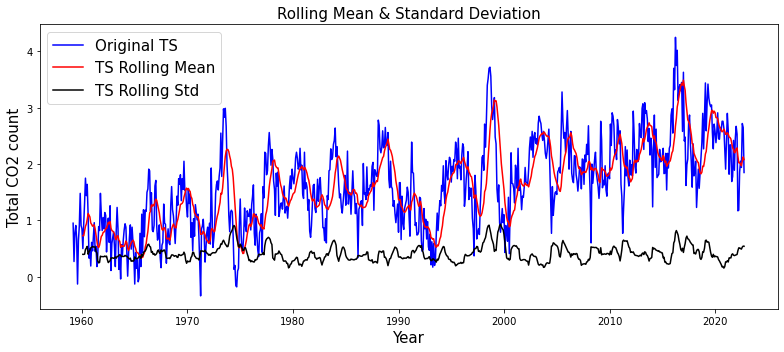

In [255]:
TestStationaryPlot(dataset_shifted_season)
DFTestStationary(dataset_shifted_season)

#### c) Seasonal first difference

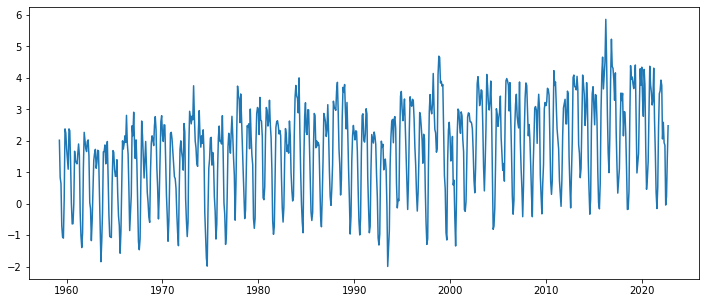

In [256]:
dataset_shifted_season_first = df_CO2_count - df_CO2_count.shift(13) #Seasonal difference
dataset_shifted_season_first.dropna(inplace = True)

plt.figure(figsize = (12,5))
plt.plot(dataset_shifted_season_first)

Dicky Fuller test:
Test statistic              -3.751139
p-value                      0.003449
Lags used                   20.000000
No of observations used    742.000000
Critical value (1%)         -3.439194
Critical value (5%)         -2.865443
Critical value (10%)        -2.568848
dtype: float64


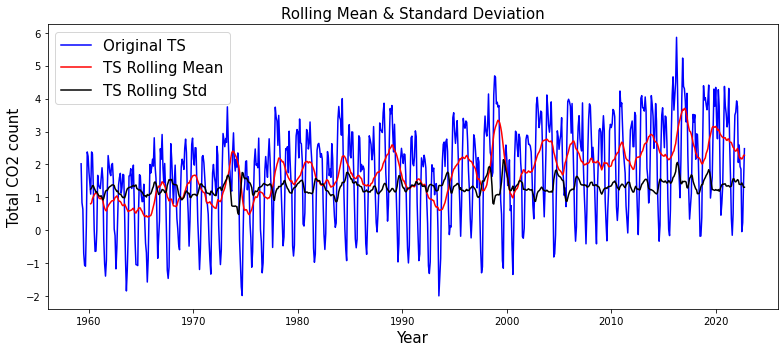

In [257]:
TestStationaryPlot(dataset_shifted_season_first)
DFTestStationary(dataset_shifted_season_first)

## Finding parametrs fo ARIMA/SARIMAX prediction models

Since we now have a choice of time series that are stationary after using the differencing method, we can now use these to help us choose the correct parameters for our predctive models

The first method of choosing these parameters is inputting our stationary TS into the autocorrelation function (ACF) and partial autocorrelation function (PACF). The time series that had the minimal amount of seasonal noise was the seasonal diffirence time series, therefore we will use this one to estmate our P and Q values using ACF and PACF plots.

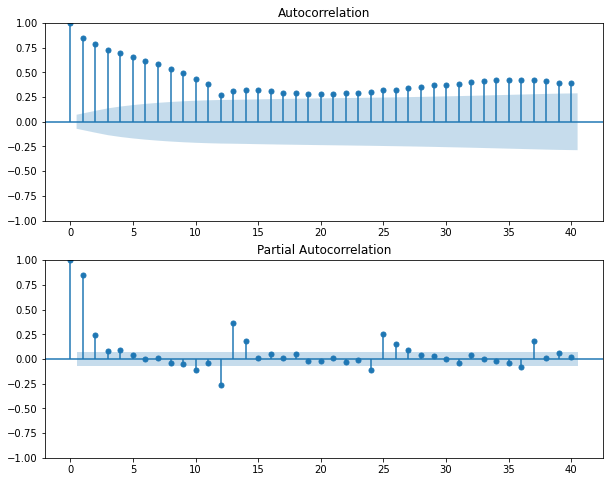

In [258]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (10,8))
plt.subplot(211)
plot_acf(dataset_shifted_season, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(dataset_shifted_season, lags=40, ax=plt.gca())
plt.show()

A slow tail can be observed on the ACF plot whilst the PACF plot drops to an insignificant value on the 3rd lag. This combinations would suggest an *AR* value of aproximately 3 and *MA* value of 0. We know the I value in are AR.*I*.MA is 1 since we can achieve a stationary series with one difference.

#### Forcasting using the ARIMA model.

Using our analysis above, we con now create models to forcast the CO2 count time series.

Firtsly, we need to split out dataset into training and test data for our model.

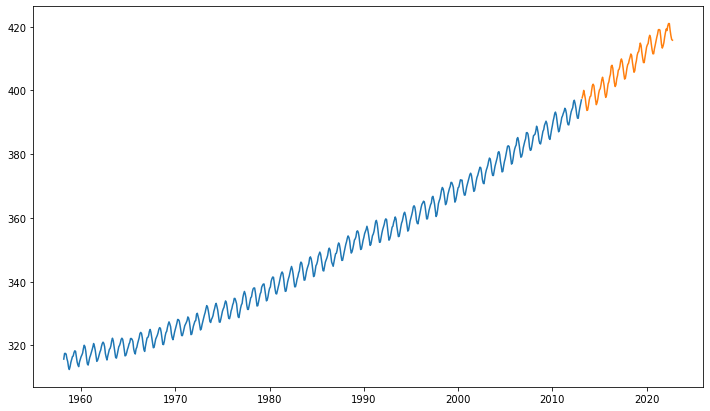

In [259]:
split = round(0.85*(len(df_CO2_count))) #length =776


train = df_CO2_count[0:split]
test = df_CO2_count[split:]

plt.plot(train)
plt.plot(test)

##### ARIMA

Using the AR, I and MA values we determined above, we can create the following ARIMA model.

Text(0.5, 1.0, 'RSS: 316.1698')

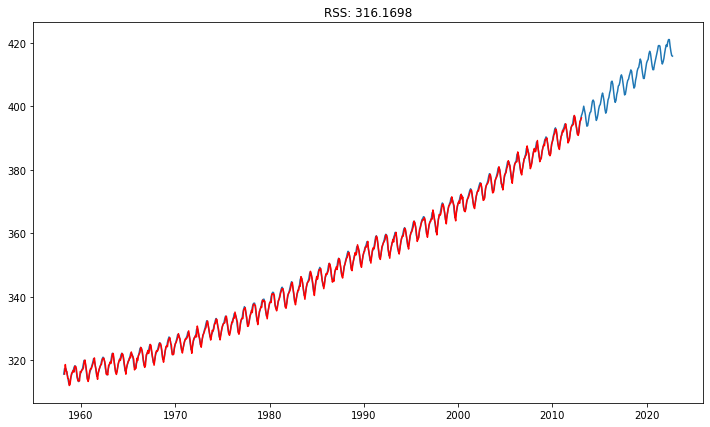

In [260]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA model
model = ARIMA(train["average_CO2_count_ppm"], order = (3,1,1))
results_ARIMA = model.fit()

results_ARIMA.summary()

plt.plot(df_CO2_count)
plt.plot(results_ARIMA.fittedvalues[1:], color = 'red' )
plt.title('RSS: %.4f'% np.sqrt(abs(sum((results_ARIMA.fittedvalues-train['average_CO2_count_ppm'])**2)))) #Calculate RSS value between our model and the original TS

After training our model, we can now use it to predict values for the second part of the time series we split, comparing the results against the test data.

Text(0.5, 1.0, 'RSS: 160.5251')

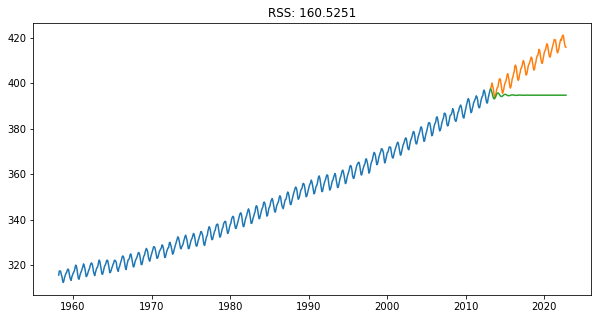

In [45]:
predict = results_ARIMA.predict(start=split,end=775,dynamic= True)

plt.figure(figsize = (10,5))
plt.plot(train)
plt.plot(test)
plt.plot(predict)
plt.title('RSS: %.4f'% np.sqrt(abs(sum((test['average_CO2_count_ppm']-predict)**2))))

We can see that this ARIMA model has performed poorly. Lets now use the SARIMAX model to try and improve our prediction. The ARIMA model doesn't seem to have accounted for seasonality, therefore the S(easonal)ARIMA model should improve our results.

##### SARIMAX

With the SARIMAX model, we can loop through a combination of pdg and PDQ (a combination of 0's and 1's) values to find the best model. We can compare the AIC attribute from each SARIMA model to find out which model fits the best. This attribute evaluates the accuracy AND efficieny of each set of parameter used.

In [261]:
import statsmodels.api as sm

In [262]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Create an array that holds all different combinations of p, q and q
pdq_PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal P, D and Q

In [263]:
pdq_PDQs # s paramter is 12 as we know our seasonality is 12 months (or rows) in our TS.

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [54]:
best_aic=np.inf # Set best AIC value to infinte. This will be replaced by smaller values obtained in our for loop.
best_mod = '' #Set empty value for our best model. This will be relpaced by models with better performing parameters.
for parameter in pdq:
    for seasonal_parameter in pdq_PDQs:
        try:
            modelS = sm.tsa.statespace.SARIMAX(train['average_CO2_count_ppm'],
                                            order=parameter,
                                            seasonal_order=seasonal_parameter,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = modelS.fit()
            if results.aic < best_aic:
                best = results
                best_aic = results.aic
                best_order = parameter
                best_seasonal_order=seasonal_parameter
        except:
            continue
            
print('TOP SARIMA{}x{} - AIC:{}'.format(best_order, best_seasonal_order, best.aic)) #Print the parameters from our best model.

TOP SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:287.41348720593726


In [264]:
print(best.summary())

                                     SARIMAX Results                                      
Dep. Variable:              average_CO2_count_ppm   No. Observations:                  660
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -138.707
Date:                            Sun, 18 Dec 2022   AIC                            287.413
Time:                                    22:39:08   BIC                            309.674
Sample:                                03-01-1958   HQIC                           296.057
                                     - 02-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0013      0.001   1478.947      0.000       1.000       1.003
ma.L1         -0.3683      0.035   

The coef column signifies the weight of each parameter on the time series. The P>|z| column shows us of the significance of each feature weight - each weight has a p-value close to 0, so it is reasonable to conclude these parameters can be used in our model.

We can examine the accuracy of our plot using the plot_diagnostics function. This shows us the difference between true and predicted values in our training data. For an good model, the residuals should be uncorrelated and the Gaussian noise centered on zero.

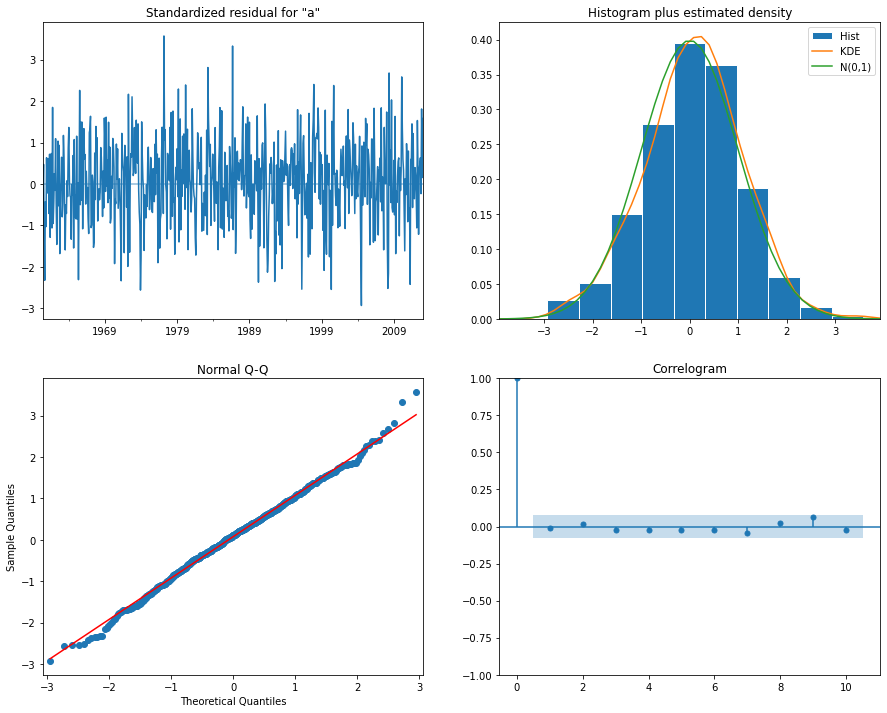

In [265]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

These plots can be analysed as follows;

1. Standardized residual: There are no obvious patterns in the residuals, suggesting a to a good model
2. Histogram plus estimated density: The histogram shows the measured distribution of the residuals, the 'kde' line shows the KDE curve (a smoothed version of the histogram), and the green line plots a normal distribution. For a good model the orange line should be similar to the green line which we have achieved with our model.
3. Normal Q-Q: Most of the data points should lie on the straight line to indicate a normal distribution of the residuals, which can be seen here.
4. Correlogram: 95% of the correlations for lags greater than one should be insignificant (in the blue area). This can also be seen on our model.

We can also create confidence bounds for our prediction using the following.

In [266]:
predict_S = best.get_prediction(start=split,end=775,dynamic= True)
pred_ci = predict_S.conf_int()
pred_ci.head()

,lower average_CO2_count_ppm,upper average_CO2_count_ppm
2013-03-01,397.130567,398.296936
2013-04-01,398.328061,399.708509
2013-05-01,398.832494,400.398484
2013-06-01,398.134485,399.866677
2013-07-01,396.549524,398.433704


Plotting our SARIMA model and our confidence bounds, we can compare our model prediction vs our 'test' portion of the TS.

Text(0, 0.5, 'CO2')

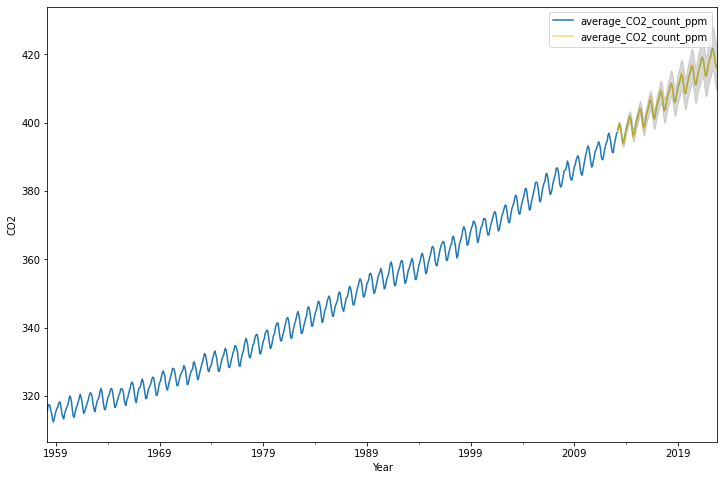

In [120]:
plt.rcParams["figure.figsize"] = [12,8]
ax = train.plot(label='observed')
predict_S.predicted_mean.plot(ax=ax, label='Forecast', color='green',alpha=.5) # Predictied values are green
test.plot(ax=ax, label='Test', alpha=.5, color = 'orange') # Test values are orange

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.3)

ax.set_xlabel('Year')
ax.set_ylabel('CO2')


To get a quantitatve evaluation of the accuracy of our prediction, we can find the mean squared error between the two sets of predicted and true values.

In [267]:
MSE = ((test['average_CO2_count_ppm']-predict_S.predicted_mean) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(MSE,3)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((test['average_CO2_count_ppm']-predict_S.predicted_mean)**2)/len(predict_S.predicted_mean))))

The Mean Squared Error (MSE) of the forecast is 0.257
The Root Mean Square Error (RMSE) of the forcast: 0.5074


### Creating CO2 levels prediction for the next 20 years.

Since we are now happy with the accuracy of our forecasting model, we can use the whoe dataset to train our model and then precist future values.

In [268]:
full_model =  sm.tsa.statespace.SARIMAX(df_CO2_count['average_CO2_count_ppm'],
                                            order=(1, 0, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

model_2 = sm.tsa.SARIMAX(df_CO2_count['average_CO2_count_ppm'], order=(3,1,4), seasonal_order = (2,1,1,12))
results_full = full_model.fit()

In [269]:
predict_full = results_full.get_prediction(start=776,end=896,dynamic= True)
pred_full_ci = predict_full.conf_int()
pred_full_ci.head()

,lower average_CO2_count_ppm,upper average_CO2_count_ppm
2022-11-01,416.874402,418.087425
2022-12-01,418.229921,419.649149
2023-01-01,419.486430,421.085899
2023-02-01,420.263599,422.025333
2023-03-01,420.853908,422.764516


Text(0, 0.5, 'CO2 count (PPM)')

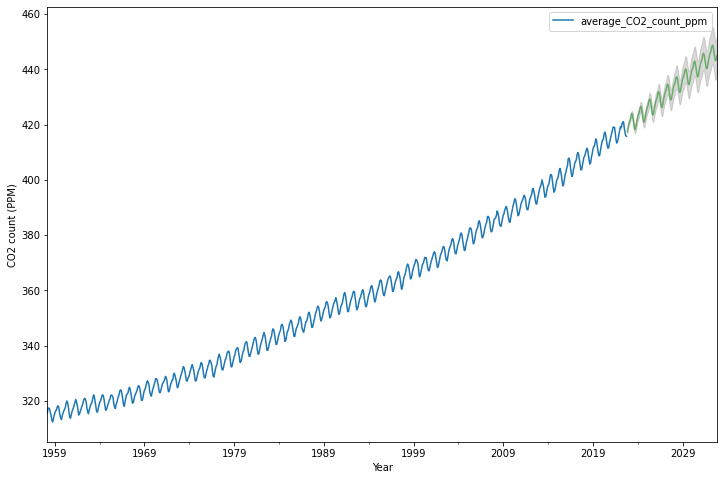

In [270]:
plt.rcParams["figure.figsize"] = [12,8]
ax = df_CO2_count.plot(label='observed')
predict_full.predicted_mean.plot(ax=ax, label='Forecast', color='green',alpha=.5)

ax.fill_between(pred_full_ci.index,
                pred_full_ci.iloc[:, 0],
                pred_full_ci.iloc[:, 1], color='grey', alpha=.3)

ax.set_xlabel('Year')
ax.set_ylabel('CO2 count (PPM)')